In [27]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

### 7.1 The catenary
An unstretchable rope with mass per unit length, $\lambda$, is suspended at the same height at both ends. Under the influence of gravity, it will hang as shown in the figure and follow what is known as the **catenary** curve.

In [28]:
a=36.78558520

### 7.2 Models
a) Set up a `torch.nn.Module` that models a function of an independent variable. Provide a method to predict the function value and its derivative.

In [29]:
class PhysicsInformed(nn.Module):
    def __init__(self, N_hidden_depth=2, N_hidden_width=8):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, N_hidden_width),
            nn.SiLU(),
            *[action for action_pair in \
              [(nn.Linear(N_hidden_width, N_hidden_width), nn.SiLU(),) for _ in range(N_hidden_depth - 1)] \
              for action in action_pair],
            nn.Linear(N_hidden_width, 1))
        self.N_epochs_trained = 0
    
    def forward(self, x):
        return self.layers(x)
    
    def prediction_and_derivative(self, x):
        prediction = self.forward(x)
        derivative = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]
        return prediction, derivative

b) Instantiate the model twice, so that one model describes $x(s)$ while the other describes $y(s)$.

In [30]:
model_x = PhysicsInformed()
model_y = PhysicsInformed()

### 7.3 Loss function
c) Set up a loss function that given some random $s$-values in the range penalizes any errors in the differential equations for $\frac{\mathrm{d}x}{\mathrm{d}s}$ and $\frac{\mathrm{d}x}{\mathrm{d}s}$.

Add to the loss function terms that cause $x(s=0)=0$, $y(s=0)=0$, $\frac{\mathrm{d}x}{\mathrm{d}s}|_{s=0}=1$, and $\frac{\mathrm{d}y}{\mathrm{d}s}|_{s=0}=0$.

In [31]:
def train(model_x, model_y, criterion, optimizer, epochs=2500, smin=0, smax=21, a=36.78558520):
    for epoch in tqdm(range(epochs), desc='Training', unit='epoch'):
        ss = torch.rand((32, 1), requires_grad=True) * (smax - smin) + smin
        s0 = torch.zeros((1, 1), requires_grad=True)
        s1 = torch.ones((1, 1), requires_grad=True)

        optimizer.zero_grad()
        _, dxds = model_x.prediction_and_derivative(ss)
        _, dyds = model_y.prediction_and_derivative(ss)
        loss = criterion(dxds, a/torch.sqrt(a**2 + ss**2))
        loss += criterion(dyds, ss/torch.sqrt(a**2 + ss**2))

        x0, slope_x0 = model_x.prediction_and_derivative(s0)
        y0, slope_y0 = model_y.prediction_and_derivative(s0)
        loss += criterion(x0, s0)
        loss += criterion(y0, y0)
        loss += criterion(slope_x0, s1)
        loss += criterion(slope_y0, s0)

        loss.backward()
        optimizer.step()
        model_x.N_epochs_trained += 1
        model_y.N_epochs_trained += 1

d) Train the neural networks.

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Training: 100%|██████████| 10000/10000 [01:05<00:00, 152.45epoch/s]


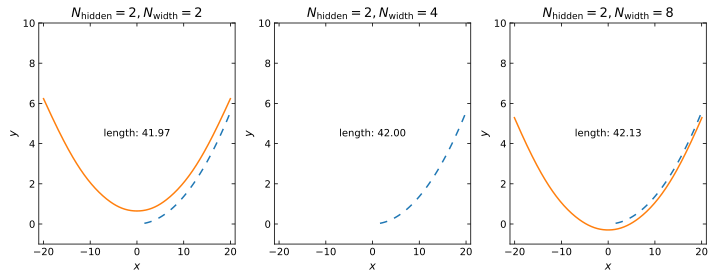

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
widths_and_depths = ((2, 2), (4, 2), (8, 2))
ss = torch.linspace(0, 21, 100, requires_grad=True).view(-1, 1)
learning_rate = 0.01
criterion = nn.MSELoss()

for ax, (w, d) in zip(axes, widths_and_depths):
    model_x = PhysicsInformed(N_hidden_width=w, N_hidden_depth=d)
    model_y = PhysicsInformed(N_hidden_width=w, N_hidden_depth=d)
    optimizer = torch.optim.Adam(
        list(model_x.parameters()) + list(model_y.parameters()),
        lr=learning_rate, weight_decay=0.0001
    )
    for j, (epochs, linestyle) in enumerate(zip([10000], ['solid'])):
        train(model_x, model_y, criterion, optimizer, epochs=epochs)
        xs = model_x(ss).detach().numpy().flatten()
        ys = model_y(ss).detach().numpy().flatten()
        xs = np.concatenate((-xs[::-1], xs))
        ys = np.concatenate((ys[::-1], ys))
        ax.plot(xs, ys, color='C1', linestyle=linestyle)
        length = np.sum(np.sqrt(np.diff(xs) ** 2 + np.diff(ys) ** 2))
        ax.text(0.5, 0.5, f'length: {length:.2f}', transform=ax.transAxes, ha='center', va='center')
    ax.set(xlabel=r'$x$', ylabel=r'$y$',
           title=r'$N_\mathrm{hidden}=' + f'{d}' + r', N_\mathrm{width}=' + f'{w}$')
    ax.set(xlim=[-21, 21], ylim=[-1, 10])
    x_np = np.linspace(0, 20, 100)
    y_np = a * np.cosh(x_np / a)
    y_np -= y_np[0]
    ax.plot(x_np, y_np, linestyle=(5, (5, 5)))

fig.savefig('ex66_fig1.png')